In [1]:
#####################################################################

## Assignment on Multiple Linear Regression

# By Sarang Thakare

#########################################################################

# Importing Libraries and Loading Data set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf # for regression model
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
import pylab          
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [4]:
startup_data=pd.read_csv("C:\\Users\\320101002\\Documents\\Data_Science\\5_Multipal_Linear_Regression\\Data\\50_Startups.csv")
startup_data.head()
startup_data.shape # Data of 50 startups, 5 features

(50, 5)

0       New York
1     California
2        Florida
3       New York
4        Florida
5       New York
6     California
7        Florida
8       New York
9     California
10       Florida
11    California
12       Florida
13    California
14       Florida
15      New York
16    California
17      New York
18       Florida
19      New York
20    California
21      New York
22       Florida
23       Florida
24      New York
25    California
26       Florida
27      New York
28       Florida
29      New York
30       Florida
31      New York
32    California
33       Florida
34    California
35      New York
36       Florida
37    California
38      New York
39    California
40    California
41       Florida
42    California
43      New York
44    California
45      New York
46       Florida
47    California
48      New York
49    California
Name: State, dtype: object
RMSE for the original model 8855.325573724913
RMSE for the model 6791.538939805914
1.1753153231430187
1.0112807816962477
2.

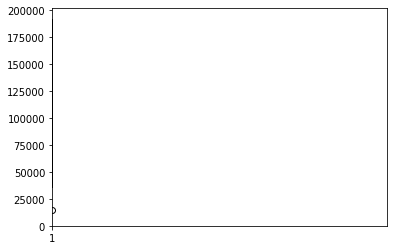

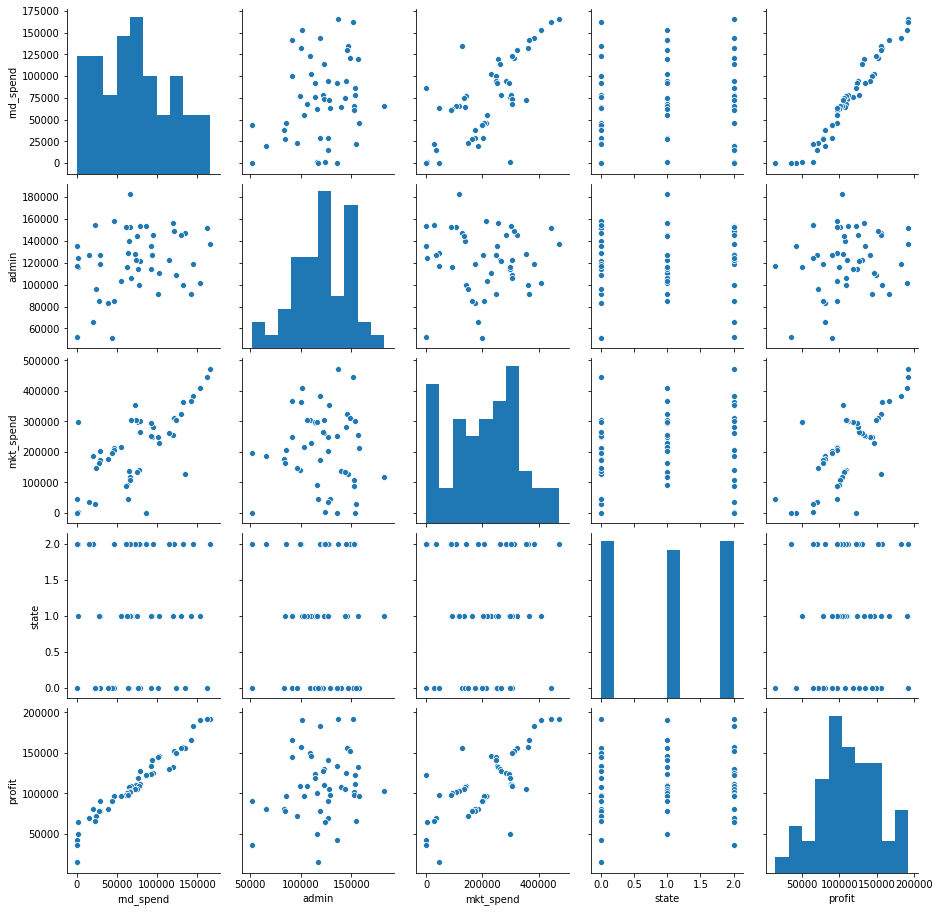

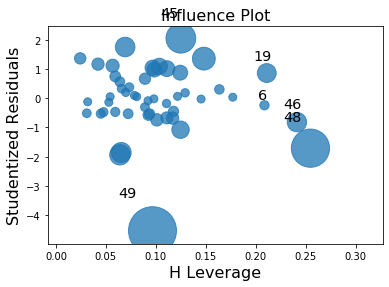

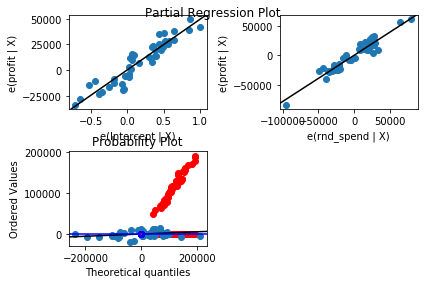

In [5]:

#########################################################################

# Data Cleaning

startup_data.isnull().sum() # To check if any null values exists
# No null values
enc = LabelEncoder()
print(startup_data['State'])
# Changing State values from factor top numeric
startup_data.State = pd.Series(enc.fit_transform(startup_data.State.astype('str')))
startup_data.head()
startup_data.columns = ['rnd_spend','admin','mkt_spend','state','profit'] # Renaming features with smaller names
# columns names
startup_data.columns

# Data Visualising
plt.hist(startup_data.profit)
plt.boxplot(startup_data.profit)
# Profit is the output variable whereas R&D_Spend, Marketing_Spoend, Adminstration_Spend and states are features

########################################################################

startup_data.corr()

# Significant factors impacting Profit are R&D Spend and Marketing Spend
# Collinearilty seen between RnD Spend and Marketing Spend
 
# Scatter plot between the variables along with histograms

sns.pairplot(startup_data)
                          
# preparing model considering all the variables 

########################################################################
         
# Preparing model                  
mlr_all = smf.ols('profit~rnd_spend+admin+mkt_spend+state',data=startup_data).fit() # regression model

# Getting coefficients of variables               
mlr_all.params
mlr_all.summary()
# p-values for R&D Spend is less than 0.05 which means R&D Spend has significant effect on Profit
# Other parameters are not very significant  
# R2 Adjusted 0.946

# RMSE value  
mlr_all_pred = mlr_all.predict(startup_data)
mlr_all_resid  = mlr_all_pred - startup_data.profit
mlr_all_rmse = np.sqrt(np.mean(mlr_all_resid*mlr_all_resid))
print("RMSE for the original model",mlr_all_rmse)
# RMSE = 8855.325

########################################################################

# Exploring Models with individual features
# We will NOT determine RMSE value for each individual 
# R2 Adjusted will be used to compare strength of each feature

# preparing model based on R&D Spend only
mlr_rnd=smf.ols('profit~rnd_spend',data = startup_data).fit()  
mlr_rnd.summary() # p value 0.00
# p-value <0.05 .. It is significant 
# R2 Adjusted  = 0.945

# preparing model based on other features individually
mlr_admin=smf.ols('profit~admin',data = startup_data).fit()  
mlr_admin.summary() # P Value 0.162
# p-value >0.05 .. Not significant 
# R2 Adjusted = 0.020 Which means no correlation

mlr_mkt=smf.ols('profit~mkt_spend',data = startup_data).fit()  
mlr_mkt.summary() # P Value 0.00
# p-value <0.05 .. Marketing Spend is significant 
# R2 Adjusted = 0.550
# It is intersting to note that when we used all features MArketing spend did not
# have significant effect whereas individual Marketing spend showed effect 
 
mlr_state=smf.ols('profit~state',data = startup_data).fit()  
mlr_state.summary() # P Value 0.482
# p-value >0.05 .. Not significant 
#R2 Adjusted = -0.010

# To summarise R&D Spend and Marketing Spend are significant features for Profit

########################################################################

# Checking whether data has any influential values 
# influence index plots

sm.graphics.influence_plot(mlr_all)

# index 49,48 and 45 show high influence so we can exclude that entire row

startup_data_n=startup_data.drop(startup_data.index[[45,48,49]],axis=0)

mlr_all_n = smf.ols('profit~rnd_spend+admin+mkt_spend+state',data=startup_data_n).fit() # regression model

# Getting coefficients of variables               
mlr_all_n.params
mlr_all_n.summary()
#R2 Adjusted improved to 0.961

mlr_all_n_pred = mlr_all_n.predict(startup_data_n)
mlr_all_n_resid  = mlr_all_n_pred - startup_data_n.profit
mlr_all_n_rmse = np.sqrt(np.mean(mlr_all_n_resid*mlr_all_n_resid))
print("RMSE for the model",mlr_all_n_rmse)
# RMSE = 6791.53 Which has been improved over oroginal model

#########################################################################

#gather features

x=startup_data.drop('profit',axis=1)
x.head()
x = x._get_numeric_data() 
x.head()
Y = startup_data['profit']

features = "+".join(x)
features
# get y and X dataframes based on this regression:
y, x = dmatrices('Y ~' + features, x, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(3)

# Summary of VIF Factors
#       2.481        RnD_Spend
#       1.175   Administration
#       2.327  Marketing_Spend
#       1.011            state
# No feature showed signoficant collimearity

########################################################################

# Alternative Method to determine VIF Factors
# Checking Collinearity between X variables
# calculating VIF's values of independent variables
rsq_admin = smf.ols('admin~rnd_spend+mkt_spend+state',data=startup_data).fit().rsquared  
vif_admin = 1/(1-rsq_admin) # 
print(vif_admin) # VIF for Admin 1.175 which is very low

rsq_state = smf.ols('state~rnd_spend+mkt_spend+admin',data=startup_data).fit().rsquared  
vif_state = 1/(1-rsq_state) # 
print(vif_state) # VIF for state 1.011 which is very low

rsq_mkt = smf.ols('mkt_spend~rnd_spend+admin+state',data=startup_data).fit().rsquared  
vif_mkt = 1/(1-rsq_mkt) # 
print(vif_mkt) # VIF for state 2.32 which is high

rsq_rnd = smf.ols('rnd_spend~mkt_spend+admin+state',data=startup_data).fit().rsquared  
vif_rnd = 1/(1-rsq_rnd) # 
print(vif_rnd) # VIF for state 2.48 which is low.. Indicates no collinearity

# Storing vif values in a data frame
vif_all = {'Variables':['rnd','mkt','admin','state'],'VIF':[vif_rnd,vif_mkt,vif_admin,vif_state]}
Vif_summary = pd.DataFrame(vif_all)  
Vif_summary

# Variables       VIF
#0       rnd  2.481178
#1       mkt  2.326780
#2     admin  1.175315
#3     state  1.011281
# No feature showed signoficant collimearity

########################################################################

# Let us see how significant each feature is on the profit. 
# We will look at the P value in the summary table, 

# And then try dropping features which are not significant 
# We will use modified data frame where we have dropped influencing observation 

# Model with all features               
mlr_all_n.params
mlr_all_n.summary()

# For state P = 0.494 > 0.05, Let us drop State

ml_rnd_mkt_admin_n = smf.ols('profit~rnd_spend+mkt_spend+admin',data=startup_data_n).fit() # regression model
# Getting coefficients of variables               
ml_rnd_mkt_admin_n.params
ml_rnd_mkt_admin_n.summary() # R2 Adjusted 0.962 which is very good

# Lets drop Admin as its P > 0.05

# Preparing model based on R&D Spend and Marketing Spend combined
mlr_rnd_mkt_n=smf.ols('profit~rnd_spend+mkt_spend',data = startup_data_n).fit()  
mlr_rnd_mkt_n.summary() # P value 0.00
mlr_rnd_mkt_n_pred = mlr_rnd_mkt_n.predict(startup_data_n)
mlr_rnd_mkt_n_resid  = mlr_rnd_mkt_n_pred - startup_data_n.profit
mlr_rnd_mkt_n_rmse = np.sqrt(np.mean(mlr_rnd_mkt_n_resid*mlr_rnd_mkt_n_resid))
print("RMSE for the model",mlr_all_n_rmse)
# RMSE = 6792 Which has been improved over oroginal model

# p-value <0.05 .. together R&D Spend and Marketing Spend are significant 
# R2 adjusted = 0.961 Which is very good
# So we should consider both features

# R2 Adjusted 0.961
# Storing the final mlr Model
final_mlr = smf.ols('profit~rnd_spend+mkt_spend',data=startup_data_n).fit() # regression model

profit_pred_final = final_mlr.predict(startup_data_n[['rnd_spend','admin','mkt_spend','state']])
profit_pred_final

######################################################################

# Added varible plot 
sm.graphics.plot_partregress_grid(final_mlr)

# Observed values VS Fitted values
plt.scatter(startup_data_n.profit,profit_pred_final,c="r");plt.xlabel("observed_values");plt.ylabel("fitted_values")

# Residuals VS Fitted Values 

plt.scatter(profit_pred_final,final_mlr.resid_pearson,c="r"),plt.axhline(y=0,color='blue');plt.xlabel("fitted_values");plt.ylabel("residuals")
# Residuals dp not show any trend which is good

########    Normality plot for residuals ######
# histogram
plt.hist(final_mlr.resid_pearson) # Checking the standardized residuals are normally distributed

# QQ plot for residuals 

# Checking Residuals are normally distributed
st.probplot(final_mlr.resid_pearson, dist="norm", plot=pylab)

# Confidence values 99%
print(final_mlr.conf_int(0.05)) # 95% confidence level

############################################################

# Summary

# Model Name       	     Features considered	                 R2 Adjusted   RMSE
# mlr_all        	     All features and All rows used	            0.946      8855
#mlr_rnd	             R and D Spend only	                        0.945
# mlr_admin	             Adminstration Spend only	                0.02
# mlr_mkt	             Marketing Spend only	                    0.55
# mlr_state	             State only	                               -0.01
# mlr_all_n	             All features, excluding 
#                        influencing rows 45, 48, 49	            0.961      6792
# mlr_rnd_mkt_admin_n	 Used featutres: R&D Spend, Marketing and
#                        Admin Dropped state and  Rows 45,48.49 	0.962  
# mlr_rnd_mkt_n	         Features used : R&D Spend and Mkt Spend
#                        Dropped  state, Admin and  Rows 45,48.49	0.961      6792

############################################################

### Splitting the data into train and test data 

startup_train,startup_test  = train_test_split(startup_data_n,test_size = 0.2) # 20% size

# preparing the model on train data 

startup_model_train = smf.ols("profit~rnd_spend",data=startup_train).fit()

# train_data prediction
startup_train_pred = startup_model_train.predict(startup_train)

# train residual values 
startup_train_resid  = startup_train_pred - startup_train.profit

# RMSE value for train data 
startup_train_rmse = np.sqrt(np.mean(startup_train_resid*startup_train_resid))

# prediction on test data set 
startup_test_pred = startup_model_train.predict(startup_test)

# test residual values 
startup_test_resid  = startup_test_pred - startup_test.profit

# RMSE value for test data 
startup_test_rmse = np.sqrt(np.mean(startup_test_resid*startup_test_resid))

print("RMSE for the test data",startup_test_rmse)

############################################################
